# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
import pandas as pd

gainArray = []
lossArray = []

predictedGain = []
predictedLoss = []
expectedGain  = []
expectedLoss  = []

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
aux = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    aux.append(myList)

aux = pd.DataFrame(aux)
scaler = MinMaxScaler()

def loadDataset(): 
    scaler.fit(aux.sample(frac=1).values.reshape(-1, 1))
    dataSet = scaler.transform(aux.values) 
    
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return abs(invertNorm(value1) - invertNorm(value2))

features, result = loadDataset()

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    global predictedGain, predictedLoss, expectedGain, expectedLoss, gainErrors, lossErrors
    
    predictedGain = []
    predictedLoss = []
    expectedGain  = []
    expectedLoss  = []
    gainErrors    = []
    lossErrors    = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else :
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            #print("Gain: ", invertNorm(predicted[0]), round(invertNorm(expected[0]), 14))
            #print("Loss: ", invertNorm(predicted[1]), round(invertNorm(expected[1]), 14))
            gainErrors.append(getError(predicted[0], expected[0]))
            lossErrors.append(getError(predicted[1], expected[1]))
            
            predictedGain.append(invertNorm(predicted[0]))
            expectedGain.append(invertNorm(expected[0]))
            predictedLoss.append(invertNorm(predicted[1]))
            expectedLoss.append(invertNorm(expected[1]))

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy): 
    global gainArray, lossArray
    
    features, result       = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray = gainErrors
    lossArray = lossErrors

# Plotting functions

In [4]:
def plotBoxplot(name):
    fig, axis = plt.subplots(figsize = (10, 5))
    gainData  = gainArray
    lossData  = lossArray
    
    aux = [gainData, lossData]

    axis.boxplot(aux)
    axis.set_title(name + " Test Error", fontsize = 16)
    axis.set_xticklabels(["Gain", "Loss"], fontsize = 14)
    axis.set_ylabel("MAE", fontsize = 14)

    plt.show()

In [5]:
def plotExpectedXPredictedGain(name):
    fig, axis = plt.subplots(figsize = (10, 5))
    predictedData = predictedGain
    expectedData  = expectedGain

    axis.scatter(x = expectedData, y = predictedData, c = 'b')
    axis.plot( [min(expectedData), max(expectedData)], [min(predictedData), max(predictedData)], 'k')
    
    axis.set_title(name + " Regression - Gain", fontsize = 16)
    axis.set_ylabel("Predicted Values", fontsize = 14)
    axis.set_xlabel("True Values", fontsize = 14)

    plt.show()

In [6]:
def plotExpectedXPredictedLoss(name):
    fig, axis = plt.subplots(figsize = (10, 5))
    predictedData = predictedLoss
    expectedData  = expectedLoss

    axis.scatter(x = expectedData, y = predictedData, c = 'r')
    axis.plot( [min(expectedData), max(expectedData)], [min(predictedData), max(predictedData)], 'k')
    
    axis.set_title(name + " Regression - Loss", fontsize = 16)
    axis.set_ylabel("Predicted Values", fontsize = 14)
    axis.set_xlabel("True Values", fontsize = 14)

    plt.show()

# Putting all together

[0.16037063 2.83962937 0.16037063 ... 0.98219373 0.98219373 0.98219373] => 2.22 (+/- 3.28)
[3.69030649 3.69030649 3.69030649 ... 3.28454416 2.28454416 2.28454416] => 2.93 (+/- 3.74)


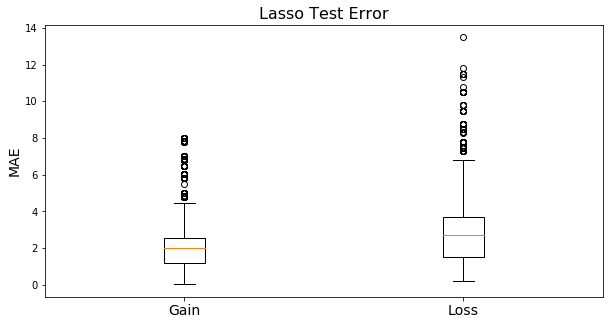

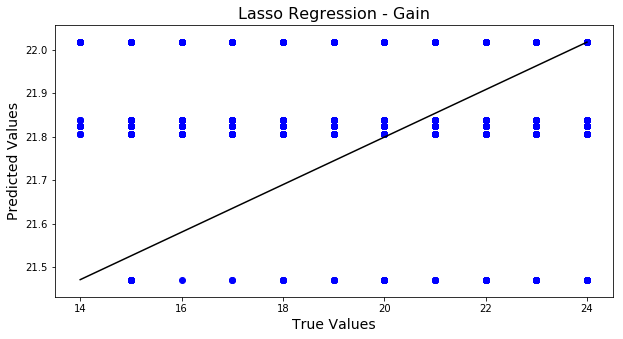

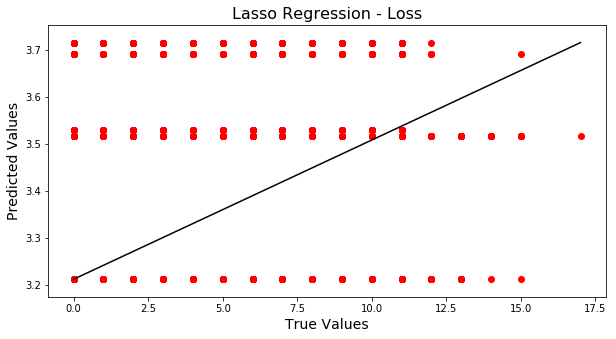

In [7]:
gainArray = []
lossArray = []
lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
trainModel(lasso)

plotBoxplot("Lasso")
plotExpectedXPredictedGain("Lasso")
plotExpectedXPredictedLoss("Lasso")

[0.24108584 2.75891416 0.24108584 ... 0.89587617 0.89587617 0.89587617] => 2.22 (+/- 3.26)
[3.66441919 3.66441919 3.66441919 ... 1.83882918 0.83882918 0.83882918] => 2.89 (+/- 3.59)


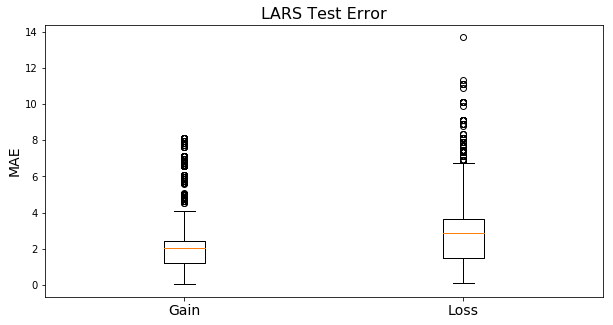

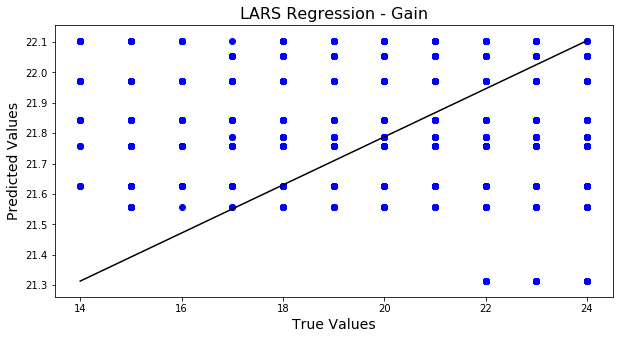

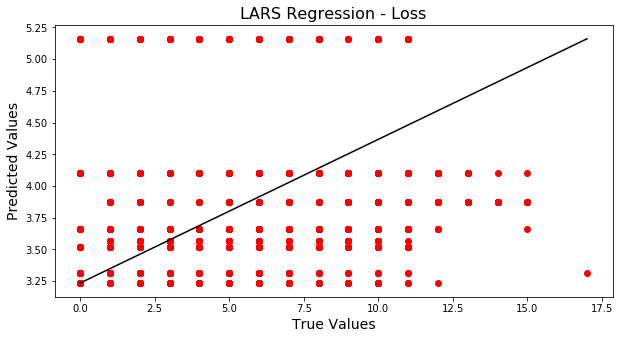

In [8]:
gainArray = []
lossArray = []
lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
trainModel(lars)

plotBoxplot("LARS")
plotExpectedXPredictedGain("LARS")
plotExpectedXPredictedLoss("LARS")

[1.75940733 1.24059267 1.75940733 ... 1.19500721 1.19500721 1.19500721] => 2.33 (+/- 3.88)
[1.7915861  1.7915861  1.7915861  ... 0.52566558 0.47433442 0.47433442] => 3.09 (+/- 4.19)


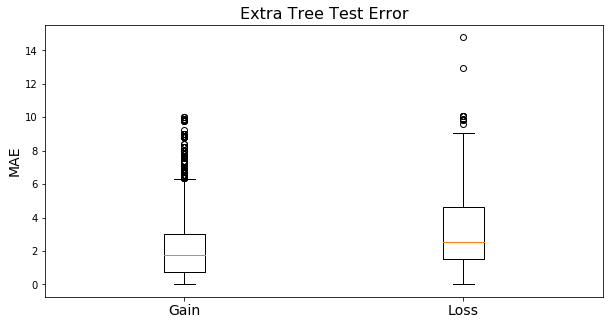

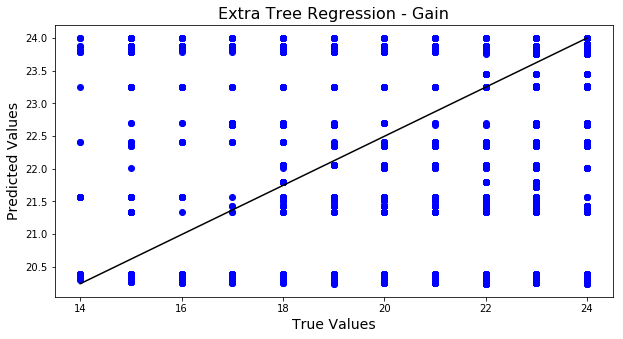

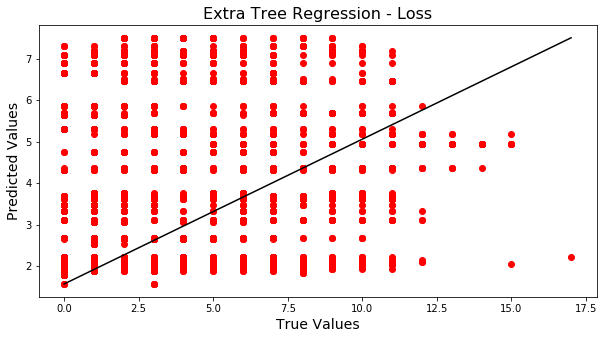

In [9]:
gainArray = []
lossArray = []
extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
trainModel(bret)

plotBoxplot("Extra Tree")
plotExpectedXPredictedGain("Extra Tree")
plotExpectedXPredictedLoss("Extra Tree")